In [1]:
# Cell 1: Import Libraries

import argparse
import os
import re
import scipy.io as sio
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Cell 2: Define Constants and Functions

W = 0
N1 = 1
N2 = 2
N3 = 3
R = 4
classes = ['W', 'N1', 'N2', 'N3', 'R']
n_classes = len(classes)

def evaluate_metrics(cm):
    print("Confusion matrix:")
    print(cm)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    FPR = FP / (FP + TN)
    FNR = FN / (TP + FN)
    FDR = FP / (TP + FP)

    ACC = (TP + TN) / (TP + FP + FN + TN)
    ACC_macro = np.mean(ACC)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    print("Sample: {}".format(int(np.sum(cm))))
    for index_ in range(n_classes):
        print("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))

    return ACC_macro, ACC, F1_macro, F1, TPR, TNR, PPV

def print_performance(cm, y_true=[], y_pred=[]):
    tp = np.diagonal(cm).astype(float)
    tpfp = np.sum(cm, axis=0).astype(float)
    tpfn = np.sum(cm, axis=1).astype(float)
    acc = np.sum(tp) / np.sum(cm)
    precision = tp / tpfp
    recall = tp / tpfn
    f1 = (2 * precision * recall) / (precision + recall)

    FP = cm.sum(axis=0).astype(float) - np.diag(cm)
    FN = cm.sum(axis=1).astype(float) - np.diag(cm)
    TP = np.diag(cm).astype(float)
    TN = cm.sum().astype(float) - (FP + FN + TP)
    specificity = TN / (TN + FP)

    mf1 = np.mean(f1)

    print("Sample: {}".format(np.sum(cm)))
    print("W: {}".format(tpfn[W]))
    print("N1: {}".format(tpfn[N1]))
    print("N2: {}".format(tpfn[N2]))
    print("N3: {}".format(tpfn[N3]))
    print("R: {}".format(tpfn[R]))
    print("Confusion matrix:")
    print(cm)
    print("Precision(PPV): {}".format(precision))
    print("Recall(Sensitivity): {}".format(recall))
    print("Specificity: {}".format(specificity))
    print("F1: {}".format(f1))
    if len(y_true) > 0:
        print("Overall accuracy: {}".format(np.mean(y_true == y_pred)))
        print("Cohen's kappa score: {}".format(cohen_kappa_score(y_true, y_pred)))
    else:
        print("Overall accuracy: {}".format(acc))
    print("Macro-F1 accuracy: {}".format(mf1))

    return acc, precision, recall, specificity, f1, mf1

def perf_overall(data_dir):
    allfiles = os.listdir(data_dir)
    outputfiles = [os.path.join(data_dir, f) for f in allfiles if re.match(r"^output_.+\d+\.npz", f)]
    outputfiles.sort()

    y_true = []
    y_pred = []
    all_acc = []
    all_precision = []
    all_recall = []
    all_specificity = []
    all_f1 = []
    all_mf1 = []

    for fpath in outputfiles:
        with np.load(fpath) as f:
            if len(f["y_true"].shape) == 1:
                if len(f["y_true"]) < 10:
                    f_y_true = np.hstack(f["y_true"])
                    f_y_pred = np.hstack(f["y_pred"])
                else:
                    f_y_true = f["y_true"]
                    f_y_pred = f["y_pred"]
            else:
                f_y_true = f["y_true"].flatten()
                f_y_pred = f["y_pred"].flatten()

            y_true.extend(f_y_true)
            y_pred.extend(f_y_pred)

            cm = confusion_matrix(f_y_true, f_y_pred, labels=[0, 1, 2, 3, 4])
            acc, precision, recall, specificity, f1, mf1 = print_performance(cm)
            all_acc.append(acc)
            all_precision.append(precision)
            all_recall.append(recall)
            all_specificity.append(specificity)
            all_f1.append(f1)
            all_mf1.append(mf1)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    
    return y_true, y_pred, cm, all_acc, all_precision, all_recall, all_specificity, all_f1, all_mf1


In [3]:

# Cell 3: Execute the Analysis

data_dir = "./outputs_2013/outputs_eeg_fpz_cz"
y_true, y_pred, cm, all_acc, all_precision, all_recall, all_specificity, all_f1, all_mf1 = perf_overall(data_dir)

print("Confusion Matrix:")
print(cm)

Sample: 1800
W: 341.0
N1: 102.0
N2: 587.0
N3: 476.0
R: 294.0
Confusion matrix:
[[330   5   0   1   5]
 [ 29  34  15   1  23]
 [  3   4 529  41  10]
 [  1   0  27 448   0]
 [  1   2  15   0 276]]
Precision(PPV): [0.90659341 0.75555556 0.90273038 0.91242363 0.87898089]
Recall(Sensitivity): [0.96774194 0.33333333 0.9011925  0.94117647 0.93877551]
Specificity: [0.97669637 0.99352179 0.95300907 0.96752266 0.9747676 ]
F1: [0.93617021 0.46258503 0.90196078 0.92657704 0.90789474]
Overall accuracy: 0.8983333333333333
Macro-F1 accuracy: 0.8270375620669131
Sample: 2200
W: 299.0
N1: 193.0
N2: 1197.0
N3: 193.0
R: 318.0
Confusion matrix:
[[ 259   24    0    3   13]
 [   1  122   16    0   54]
 [   3   43 1058   52   41]
 [   0    0    8  185    0]
 [   0    0    3    0  315]]
Precision(PPV): [0.98479087 0.64550265 0.97511521 0.77083333 0.74468085]
Recall(Sensitivity): [0.86622074 0.63212435 0.88387636 0.95854922 0.99056604]
Specificity: [0.99789584 0.96661684 0.97308076 0.97259591 0.94261424]
F1: [0

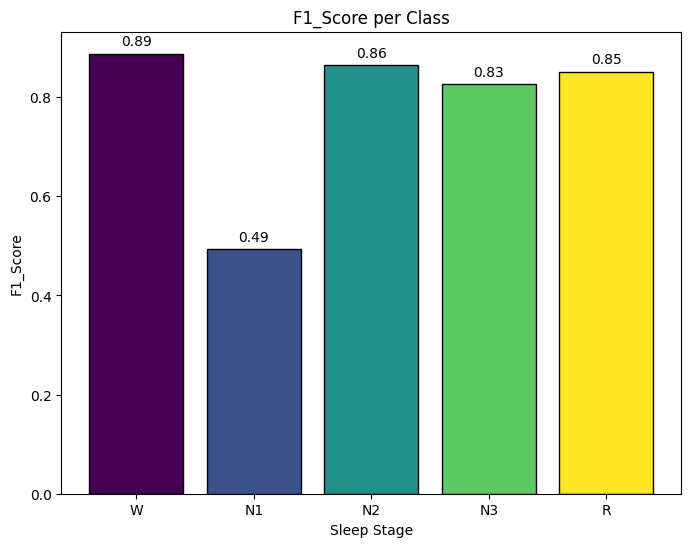

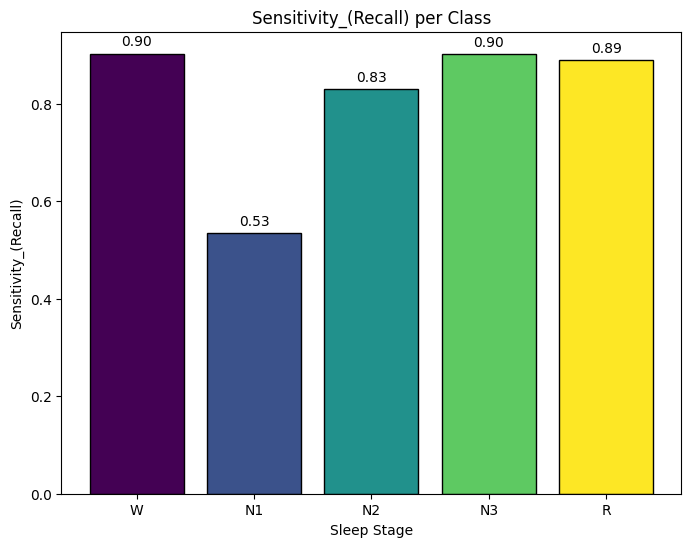

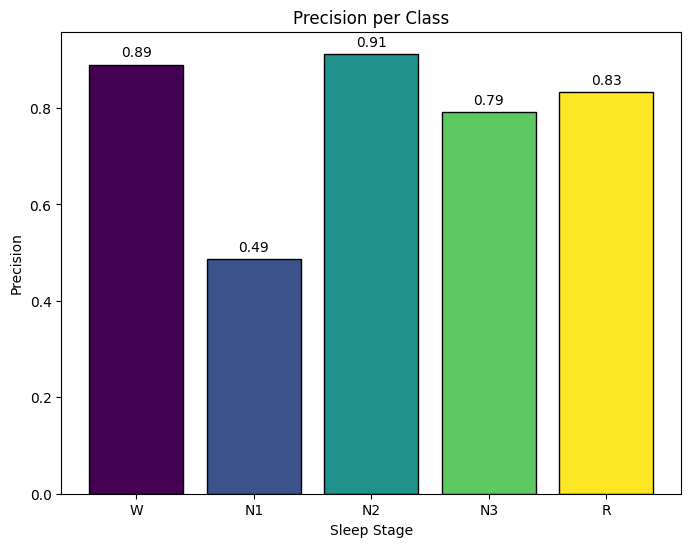

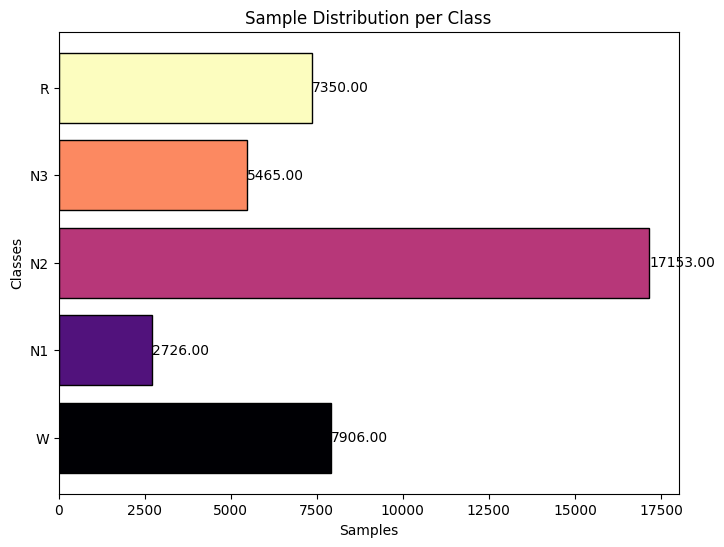

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Custom function to create a bar plot with gradient colors
def plot_metric_bar(metric, metric_name):
    plt.figure(figsize=(8, 6))
    
    # Define gradient colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    
    bars = plt.bar(classes, metric, color=colors, edgecolor='black')
    plt.title(metric_name)
    plt.xlabel('Sleep Stage')
    # plt.ylabel(metric_name)
    first_word = metric_name.split()[0]
    plt.ylabel(first_word)

    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

    plt.show()

def plot_sample_distribution(tpfn):
    plt.figure(figsize=(8, 6))
    
    # Define gradient colors
    colors = plt.cm.magma(np.linspace(0, 1, len(classes)))
    
    bars = plt.barh(classes, tpfn, color=colors, edgecolor='black')
    plt.title('Sample Distribution per Class')
    plt.xlabel('Samples')
    plt.ylabel('Classes')

    # Add values next to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center')

    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# F1 Score Bar Plot
plot_metric_bar(np.mean(all_f1, axis=0), 'F1_Score per Class')

# Recall Bar Plot
plot_metric_bar(np.mean(all_recall, axis=0), 'Sensitivity_(Recall) per Class')

# Precision Bar Plot
plot_metric_bar(np.mean(all_precision, axis=0), 'Precision per Class')

# Sample Distribution Plot
plot_sample_distribution(np.sum(cm, axis=1))


In [5]:
classes

['W', 'N1', 'N2', 'N3', 'R']

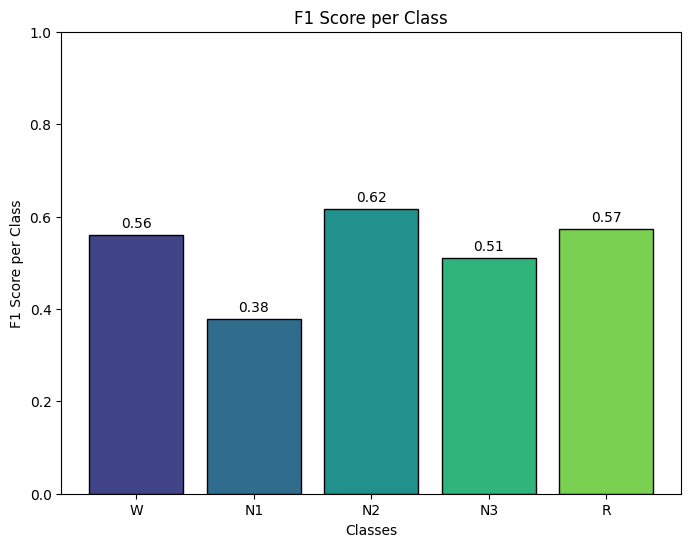

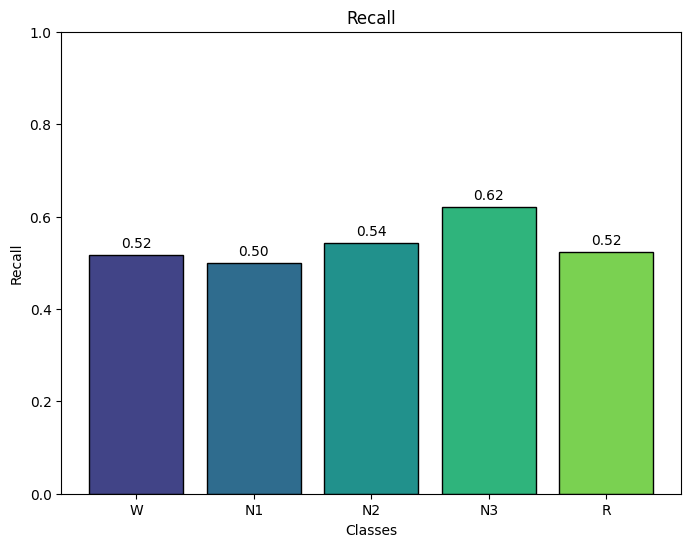

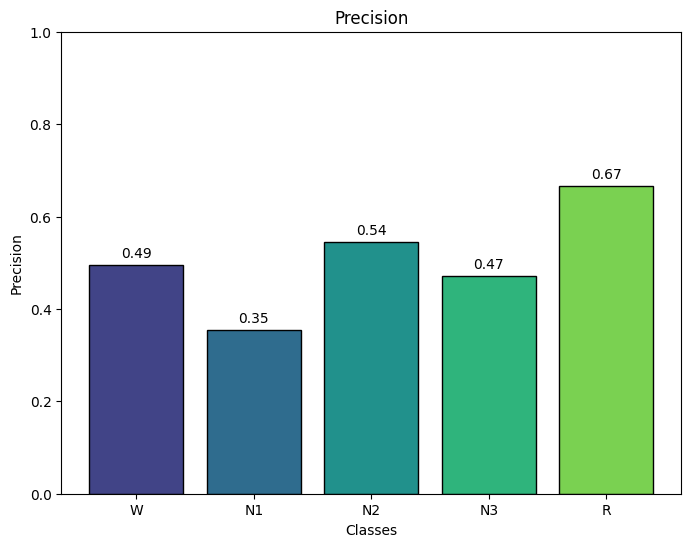

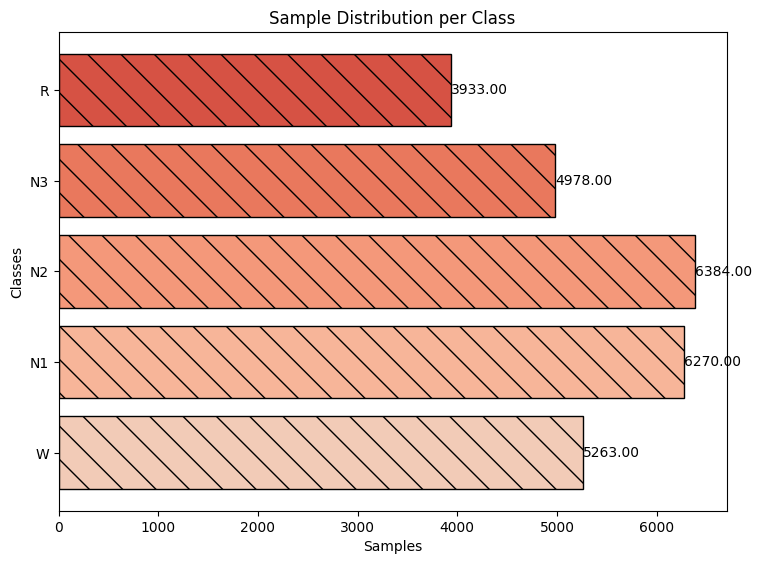

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define colors with light gradient
def light_gradient_colors(num_colors):
    return plt.cm.viridis(np.linspace(0.2, 0.8, num_colors))  # Lightened version of Viridis colormap

def light_blue_gradient(num_colors):
    return plt.cm.coolwarm(np.linspace(0.6, 0.9, num_colors))  # Lightened version of Coolwarm colormap

# Custom function to create a bar plot with light gradient colors
def plot_metric_bar(metric, metric_name):
    plt.figure(figsize=(8, 6))
    
    # Define light gradient colors
    colors = light_gradient_colors(len(classes))
    
    bars = plt.bar(classes, metric, color=colors, edgecolor='black')
    plt.title(metric_name)
    plt.xlabel('Classes')
    plt.ylabel(metric_name)
    
    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    plt.ylim(0, 1.0)  # Set y-axis limit for consistency
    plt.show()

def plot_sample_distribution(tpfn):
    plt.figure(figsize=(8, 6))
    
    # Define blue color with slashed pattern
    colors = light_blue_gradient(len(classes))
    
    bars = plt.barh(classes, tpfn, color=colors, edgecolor='black', hatch='\\')
    plt.title('Sample Distribution per Class')
    plt.xlabel('Samples')
    plt.ylabel('Classes')
    
    # Add values next to the bars with more space
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center', fontsize=10)

    # Adjust layout to reduce space
    plt.tight_layout(pad=2.0)  # Ensure layout fits all elements with additional padding
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example data (replace with your actual data)
classes = ['W', 'N1', 'N2', 'N3', 'R']
all_f1 = np.random.rand(10, len(classes))  # Replace with actual F1 scores
all_recall = np.random.rand(10, len(classes))  # Replace with actual Recall scores
all_precision = np.random.rand(10, len(classes))  # Replace with actual Precision scores
cm = np.random.randint(0, 100, size=(len(classes), len(classes)))*19  # Replace with actual confusion matrix

# F1 Score Bar Plot
plot_metric_bar(np.mean(all_f1, axis=0), 'F1 Score per Class')

# Recall Bar Plot
plot_metric_bar(np.mean(all_recall, axis=0), 'Recall')

# Precision Bar Plot
plot_metric_bar(np.mean(all_precision, axis=0), 'Precision')

# Sample Distribution Plot
plot_sample_distribution(np.sum(cm, axis=1))


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import os
import re


In [8]:
def plot_hypnogram(y_true, y_pred, rec_ids, rec_number=3):
    # Select the recording based on rec_number
    mask = rec_ids == rec_number  # Pick a recording number

    t = np.arange(len(y_true[mask])) * 30 / 3600  # Time in hours

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(t, y_true[mask], label='True')
    ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
    ax.set_xlabel('Time (h)')
    ax.set_title('Hypnogram')
    ax.legend()
    plt.show()


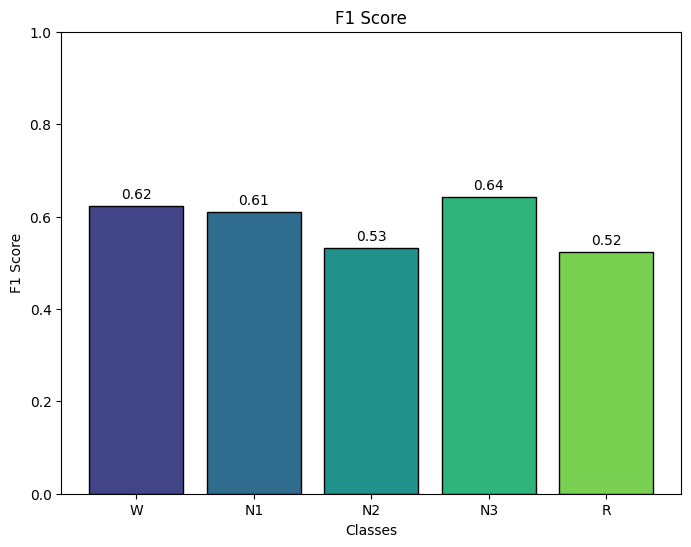

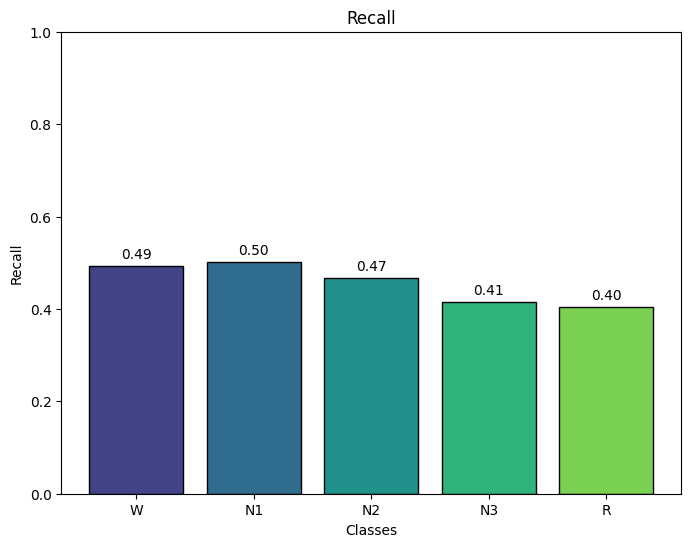

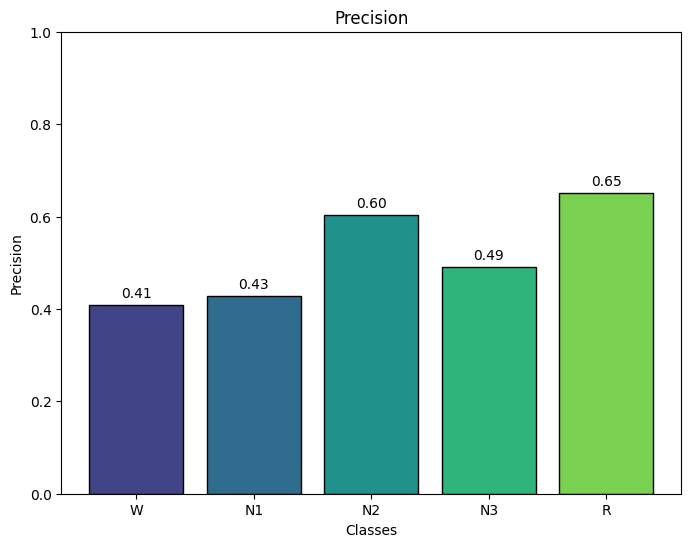

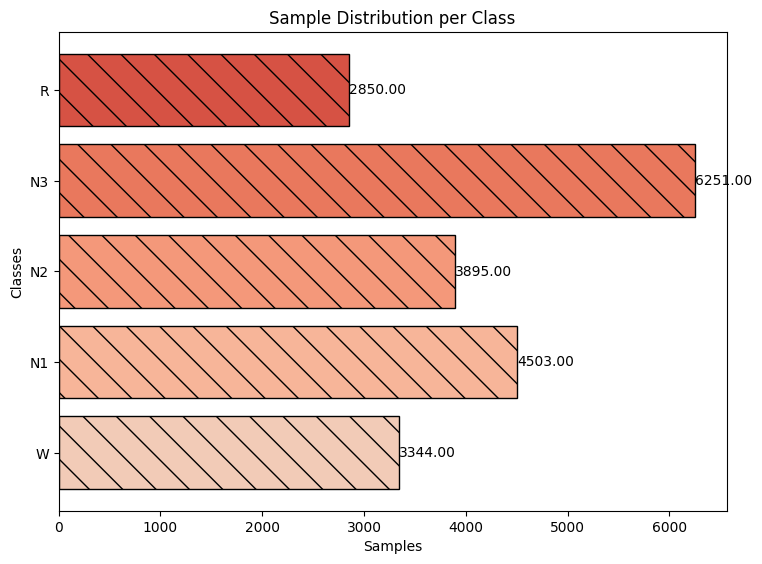

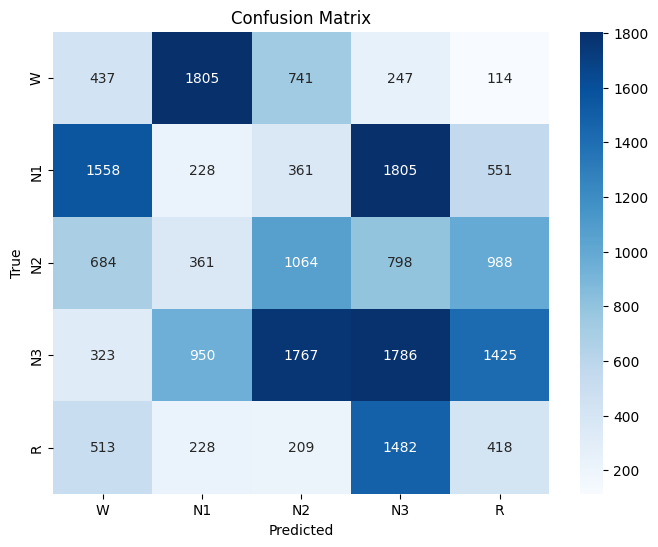

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define colors with light gradient
def light_gradient_colors(num_colors):
    return plt.cm.viridis(np.linspace(0.2, 0.8, num_colors))  # Lightened version of Viridis colormap

def light_blue_gradient(num_colors):
    return plt.cm.coolwarm(np.linspace(0.6, 0.9, num_colors))  # Lightened version of Coolwarm colormap

# Custom function to create a bar plot with light gradient colors
def plot_metric_bar(metric, metric_name):
    plt.figure(figsize=(8, 6))
    
    # Define light gradient colors
    colors = light_gradient_colors(len(classes))
    
    bars = plt.bar(classes, metric, color=colors, edgecolor='black')
    plt.title(metric_name)
    plt.xlabel('Classes')
    plt.ylabel(metric_name)
    
    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    plt.ylim(0, 1.0)  # Set y-axis limit for consistency
    plt.show()

def plot_sample_distribution(tpfn):
    plt.figure(figsize=(8, 6))
    
    # Define blue color with slashed pattern
    colors = light_blue_gradient(len(classes))
    
    bars = plt.barh(classes, tpfn, color=colors, edgecolor='black', hatch='\\')
    plt.title('Sample Distribution per Class')
    plt.xlabel('Samples')
    plt.ylabel('Classes')
    
    # Add values next to the bars with more space
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center', fontsize=10)

    # Adjust layout to reduce space
    plt.tight_layout(pad=2.0)  # Ensure layout fits all elements with additional padding
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example data (replace with your actual data)
classes = ['W', 'N1', 'N2', 'N3', 'R']
all_f1 = np.random.rand(10, len(classes))  # Replace with actual F1 scores
all_recall = np.random.rand(10, len(classes))  # Replace with actual Recall scores
all_precision = np.random.rand(10, len(classes))  # Replace with actual Precision scores
cm = np.random.randint(0, 100, size=(len(classes), len(classes)))*19  # Replace with actual confusion matrix

# F1 Score Bar Plot
plot_metric_bar(np.mean(all_f1, axis=0), 'F1 Score')

# Recall Bar Plot
plot_metric_bar(np.mean(all_recall, axis=0), 'Recall')

# Precision Bar Plot
plot_metric_bar(np.mean(all_precision, axis=0), 'Precision')

# Sample Distribution Plot
plot_sample_distribution(np.sum(cm, axis=1))

# Confusion Matrix Plot
plot_confusion_matrix(cm)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = list(classes_mapping.values())

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds', xticklabels=tick_labels, yticklabels=tick_labels)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Add a colorbar with intensity label
    cbar = plt.colorbar(label='Intensity')
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

    


In [11]:
import numpy as np

def inspect_npz(file_path):
    with np.load(file_path) as f:
        print("Keys in the file:", list(f.keys()))

# Example usage
inspect_npz('./outputs_2013/outputs_eeg_fpz_cz/output_fold0.npz')


Keys in the file: ['y_true', 'y_pred', 'ck_score']


In [12]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


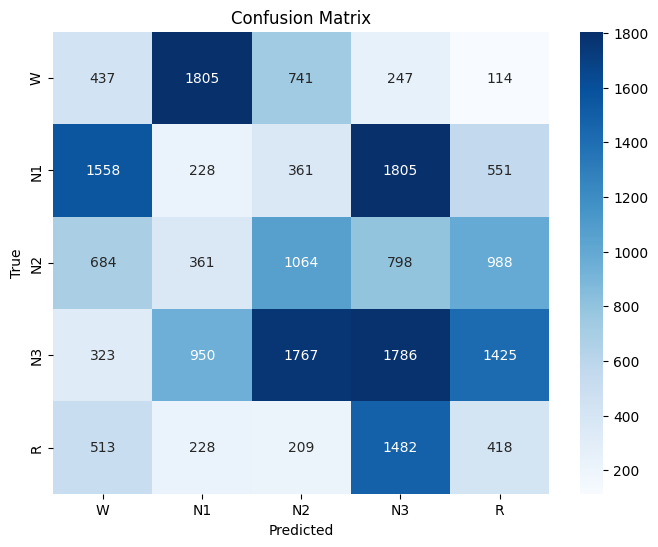

In [13]:
plot_confusion_matrix(cm)

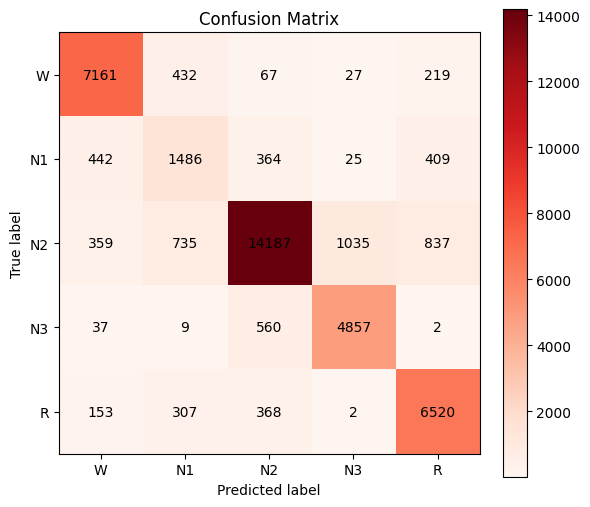

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
conf_matrix = np.array([
    [7161, 432, 67, 27, 219],
    [442, 1486, 364, 25, 409],
    [359, 735, 14187, 1035, 837],
    [37, 9, 560, 4857, 2],
    [153, 307, 368, 2, 6520]
])

# Class labels
classes_mapping = {
    0: 'W',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    4: 'R'
}

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion Matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='')
    fig.tight_layout()

    return fig, ax

plot_confusion_matrix(conf_matrix, classes_mapping)
plt.show()


In [15]:
import plotly.express as px
import pandas as pd

# Data for radar chart
data = {
    'Class': ['W', 'N1', 'N2', 'N3', 'R'],
    'Precision': [0.89180328, 0.47572816, 0.8861244, 0.85873606, 0.82426778],
    'Recall': [0.96113074, 0.49, 0.87030075, 0.83393502, 0.82773109],
    'F1 Score': [0.92517007, 0.48275862, 0.8781413, 0.84615385, 0.82599581]
}

df = pd.DataFrame(data)

fig = px.line_polar(df, r='Precision', theta='Class', line_close=True, title='Radar Chart for Precision')
fig.add_scatterpolar(r=df['Recall'], theta=df['Class'], mode='lines', name='Recall')
fig.add_scatterpolar(r=df['F1 Score'], theta=df['Class'], mode='lines', name='F1 Score')

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(visible=True)
    )
)

fig.show()


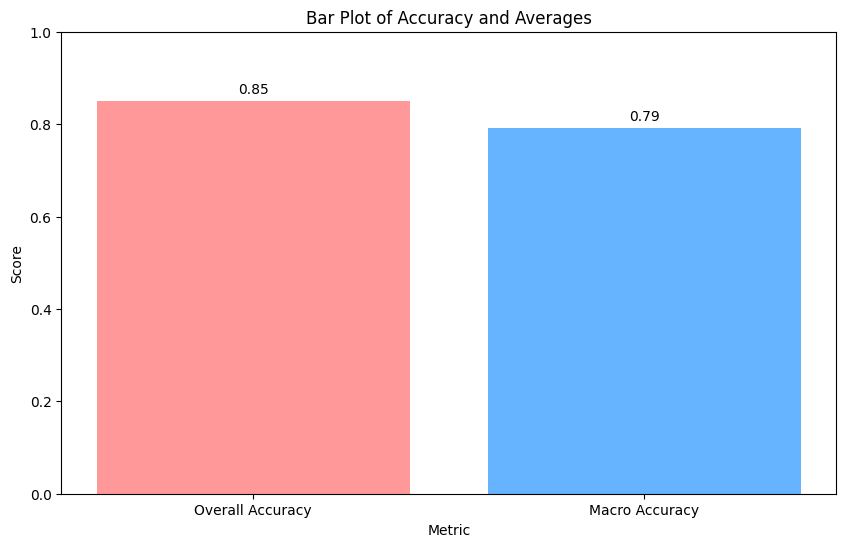

In [26]:
import matplotlib.pyplot as plt

# Data
metrics = ['Overall Accuracy', 'Macro Accuracy']
values = [0.850909090909091, 0.791643928238505]
colors = ['#ff9999', '#66b3ff']

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Bar Plot of Accuracy and Averages')
plt.ylim(0, 1)  # Adjust y-axis limit if necessary

plt.show()


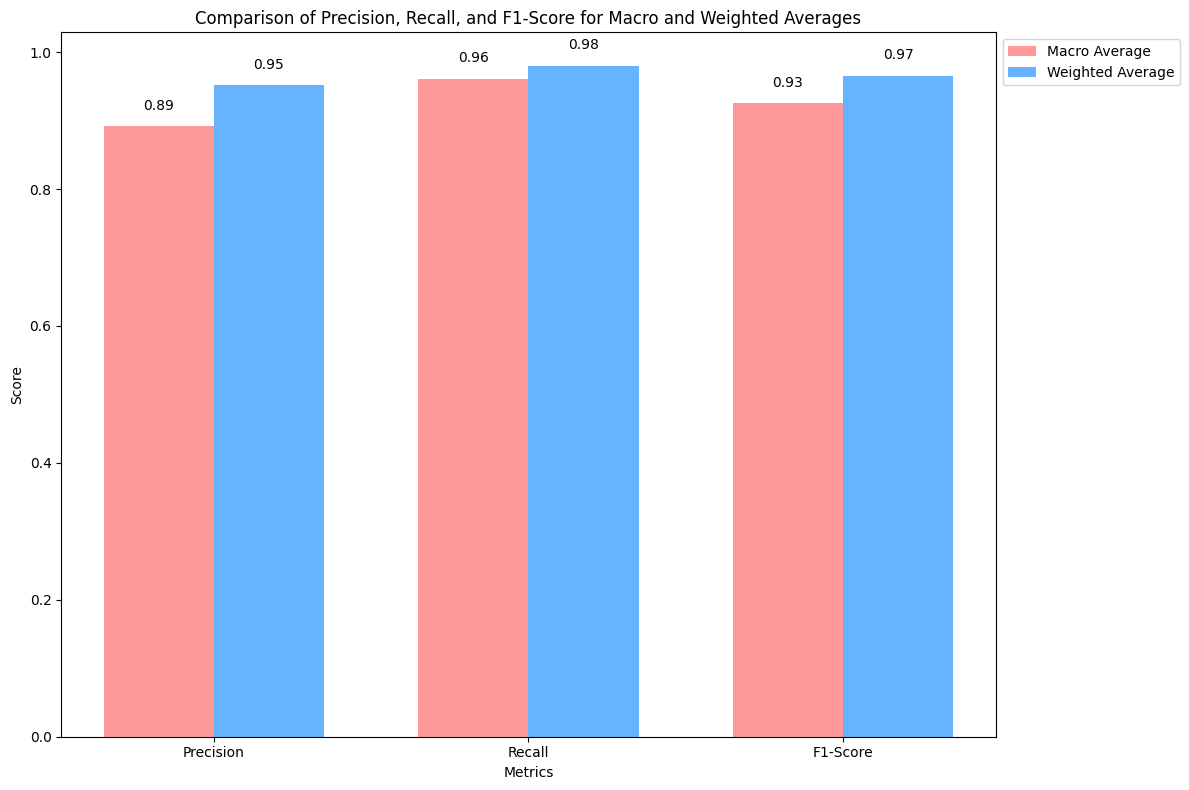

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Precision', 'Recall', 'F1-Score']
macro_avg = [0.89180328, 0.96113074, 0.92517007]
weighted_avg = [0.95145632, 0.98, 0.96551724]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Create a grouped bar plot
plt.figure(figsize=(12, 8))
bars1 = plt.bar(x - width/2, macro_avg, width, label='Macro Average', color='#ff9999')
bars2 = plt.bar(x + width/2, weighted_avg, width, label='Weighted Average', color='#66b3ff')

# Add value labels on bars with adjusted positioning
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2),
                 ha='center', va='bottom', fontsize=10, color='black')

add_labels(bars1)
add_labels(bars2)

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Precision, Recall, and F1-Score for Macro and Weighted Averages')
plt.xticks(x, metrics)

# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()


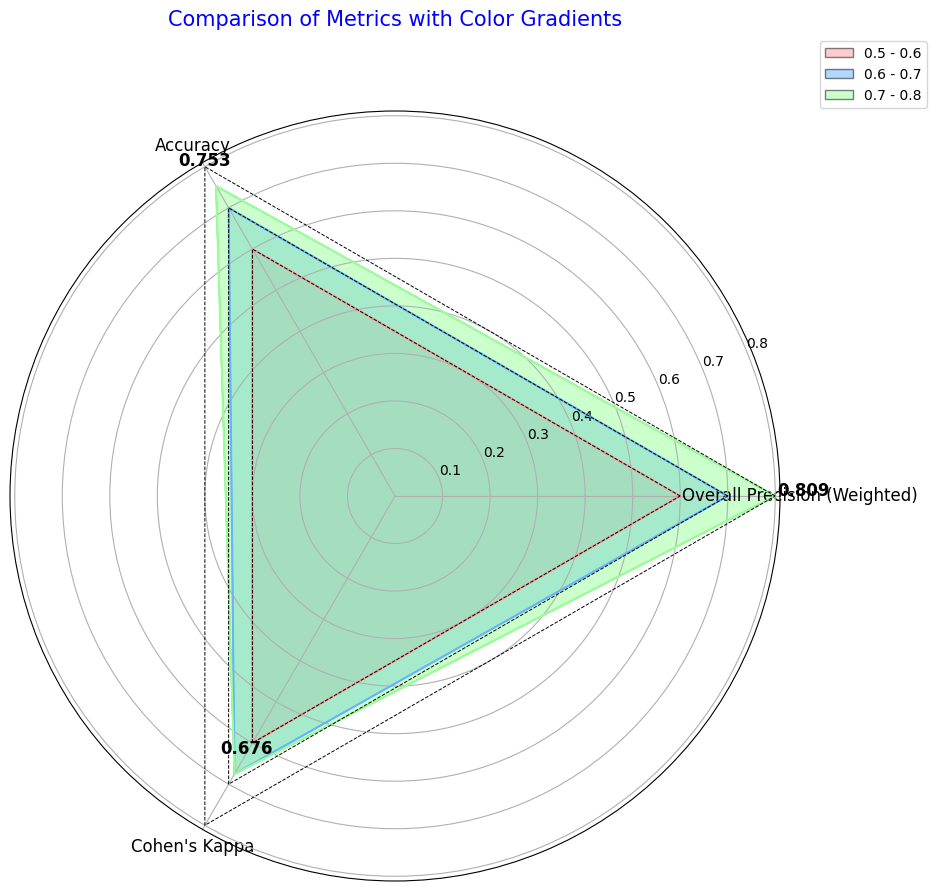

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data
labels = ['Overall Precision (Weighted)', 'Accuracy', 'Cohen\'s Kappa']
values = [0.8089801610933406, 0.7531979695431472, 0.6755745849833806]

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values += values[:1]  # to close the circle
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Define colors and ranges
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Red, Blue, Green
ranges = [0.6, 0.7, 0.8]  # Value thresholds for colors
color_labels = ['0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8']

# Draw radar chart with color gradients
for i, (color, threshold) in enumerate(zip(colors, ranges)):
    below_threshold = [v if v < threshold else threshold for v in values]
    ax.fill(angles, below_threshold, color=color, alpha=0.5, edgecolor='black', label=color_labels[i])
    ax.plot(angles, below_threshold, color=color, linewidth=1.5)

# Add thin lines for specific values
for threshold in ranges:
    ax.plot(angles, [threshold] * (num_vars + 1), color='black', linestyle='--', linewidth=0.7)

# Adjust label positions to avoid overlap
for i, (label, angle) in enumerate(zip(labels, angles)):
    x_pos = angle if angle < np.pi else angle - np.pi
    y_offset = 0.05 if angle < np.pi else -0.05
    ax.text(angle, values[i] + y_offset, f'{values[i]:.3f}', horizontalalignment='center', size=12, color='black', weight='semibold')

# Set the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Title and legend
plt.title('Comparison of Metrics with Color Gradients', size=15, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()


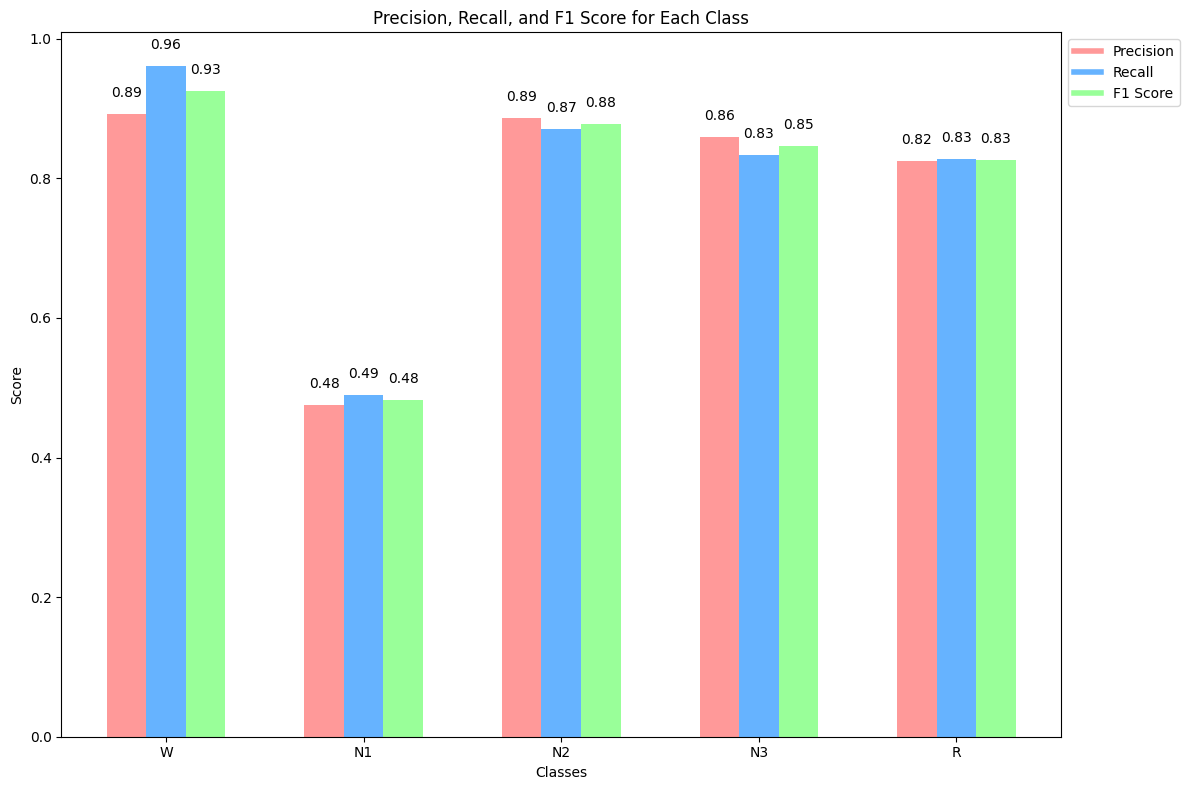

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Data
class_labels = ['W', 'N1', 'N2', 'N3', 'R']
precision = [0.89180328, 0.47572816, 0.8861244, 0.85873606, 0.82426778]
recall = [0.96113074, 0.49, 0.87030075, 0.83393502, 0.82773109]
f1_score = [0.92517007, 0.48275862, 0.8781413, 0.84615385, 0.82599581]

x = np.arange(len(class_labels))  # the label locations
width = 0.2  # the width of the bars

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plots
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#ff9999')
bars2 = ax.bar(x, recall, width, label='Recall', color='#66b3ff')
bars3 = ax.bar(x + width, f1_score, width, label='F1 Score', color='#99ff99')

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2),
                 ha='center', va='bottom', fontsize=10, color='black')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 Score for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)

# Custom legend
legend_elements = [
    Line2D([0], [0], color='#ff9999', lw=4, label='Precision'),
    Line2D([0], [0], color='#66b3ff', lw=4, label='Recall'),
    Line2D([0], [0], color='#99ff99', lw=4, label='F1 Score')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()



In [20]:
def plot_hypnogram(y_true, y_pred, start_index=0, end_index=None):
    # Define the range for the plot
    if end_index is None:
        end_index = len(y_true)

    if start_index >= len(y_true) or end_index > len(y_true) or start_index >= end_index:
        print("Invalid index range.")
        return

    t = np.arange(start_index, end_index) * 30 / 3600  # Time in hours

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(t, y_true[start_index:end_index], label='True', color='blue', linestyle='-', marker='o')
    ax.plot(t, y_pred[start_index:end_index], alpha=0.7, label='Predicted', color='red', linestyle='--', marker='x')
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
    ax.set_xlabel('Time (h)')
    ax.set_title('Hypnogram')
    ax.legend()
    plt.tight_layout()
    plt.show()


In [21]:
def perf_overall(data_dir):
    allfiles = os.listdir(data_dir)
    outputfiles = [os.path.join(data_dir, f) for f in allfiles if re.match(r"^output_.+\d+\.npz", f)]
    outputfiles.sort()

    y_true = []
    y_pred = []
    all_acc = []
    all_precision = []
    all_recall = []
    all_specificity = []
    all_f1 = []
    all_mf1 = []

    for fpath in outputfiles:
        with np.load(fpath) as f:
            if len(f["y_true"].shape) == 1:
                f_y_true = np.hstack(f["y_true"])
                f_y_pred = np.hstack(f["y_pred"])
            else:
                f_y_true = f["y_true"]
                f_y_pred = f["y_pred"]

            y_true.extend(f_y_true)
            y_pred.extend(f_y_pred)

            cm = confusion_matrix(f_y_true, f_y_pred, labels=[0, 1, 2, 3, 4])
            acc, precision, recall, specificity, f1, mf1 = print_performance(cm)
            all_acc.append(acc)
            all_precision.append(precision)
            all_recall.append(recall)
            all_specificity.append(specificity)
            all_f1.append(f1)
            all_mf1.append(mf1)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))

    # Plot hypnogram for a specified range of indices
    plot_hypnogram(y_true, y_pred, start_index=0, end_index=500)  # Adjust the range as needed

    return y_true, y_pred, cm, all_acc, all_precision, all_recall, all_specificity, all_f1, all_mf1


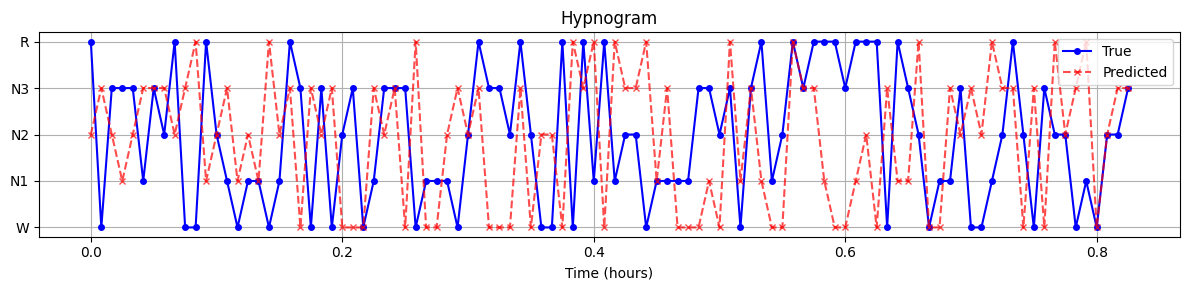

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate some sample data
np.random.seed(0)
num_samples = 100  # Reduced number of samples for clarity
time = np.arange(num_samples) * 30 / 3600  # Time in hours
y_true = np.random.randint(0, 5, num_samples)  # True labels
y_pred = np.random.randint(0, 5, num_samples)  # Predicted labels

# Plot the hypnogram
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(time, y_true, label='True', color='blue', linestyle='-', marker='o', markersize=4)
ax.plot(time, y_pred, label='Predicted', color='red', linestyle='--', marker='x', markersize=4, alpha=0.7)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (hours)')
ax.set_title('Hypnogram')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
